# assessment of correlation between replicates using different snp window sizes

## This suggests 100 snp windows (which we used in the preprint) are too small. 500 snp windows provides much high correlation while still maintain reasonably small physical window sizes (~100Kb).

In [1]:
library(unglue)
library(tidyverse)
library(patchwork)
library(glue)
options(repr.plot.width=10, repr.plot.height=10)
theme_set(theme_classic(20))

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
overlap_files <- fs::dir_ls("overlaps/")

In [3]:
overlap_files <- fs::dir_ls("overlaps/")

suppressMessages(suppressWarnings(
#count up sweep stuff for each rep, pop, and total
grid_df <- overlap_files %>% 
map_df(~{
    df  <- vroom::vroom(.x, col_names = c("chrom", "start", "end", "size", "files")) %>%
    summarise(
         total = n(),
         size = mean(size),
         LR = sum(grepl("LR--random[12]_Palmar_Chico", files)), 
         Teo = sum(grepl("Teo--random[12]_Palmar_Chico", files)),
         LR_shared = sum(grepl("LR--random1", files) & grepl("LR--random2", files)),
         Teo_shared = sum(grepl("Teo--random1", files) & grepl("Teo--random2", files)),        
         LR_random1 = sum(grepl("LR--random1", files)),
         LR_random2 = sum(grepl("LR--random2", files)),
         Teo_random1 = sum(grepl("Teo--random1", files)),
         Teo_random2 = sum(grepl("Teo--random2", files)),
    ) %>% 
    mutate(LR_prop = LR_shared/LR, Teo_prop = Teo_shared/Teo, mean_prop = (LR_prop + Teo_prop)/2)                       
    meta <- unglue(.x, "overlaps/allpops_window{window}_maf{maf}_quantile{quantile}_merge{merge}.txt")  %>% 
    map_df(function(x) x)
    df <- mutate(df, meta) %>% mutate(window = as.numeric(window), maf = as.numeric(maf), quantile = as.numeric(quantile), merge = as.numeric(merge))
})
))


In [4]:
#across parameter combinations, is there clear bias for teo pops have more singleton sweeps?

all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--random1_Palmar_Chico", 
    "v5--LR--random", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--random1_Palmar_Chico", 
    "v5--Teo--random", 
    "v5--Teo--San_Lorenzo"
)

suppressMessages(
mean_unique_df <- overlap_files %>% map_df(function(i){
    meta <- unglue(i, "overlaps/allpops_window{window}_maf{maf}_quantile{quantile}_merge{merge}.txt")[[1]]
    df_test  <- vroom::vroom(i, col_names = c("chrom", "start", "end", "size", "files")) %>% 
        mutate(
            LR_count = str_count(files, "LR"),
            Teo_count = str_count(files, "Teo")
        ) 

    all_pops %>% 
        map_df(~{
            focal_pop_df <-  filter(df_test, grepl(.x, files))
            if(grepl("LR", .x)){
                unique_pop_count  <-  nrow(filter(focal_pop_df, LR_count == 1 & Teo_count == 0))
                subsp  <- "LR"
            } else {
                unique_pop_count <- nrow(filter(focal_pop_df, LR_count == 0 & Teo_count == 1))
                subsp  <- "Teo"
            }
        tibble(
            pop = .x, 
            prop_unique = unique_pop_count/nrow(focal_pop_df),
            subsp = subsp
        ) %>% 
            bind_cols(., meta)
        }) %>% 
        group_by(subsp, window, maf, quantile, merge) %>% 
        summarise(mean_unique_prop = mean(prop_unique))
})
)


Warning message:
“Removed 84 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 55 rows containing non-finite values (stat_density).”


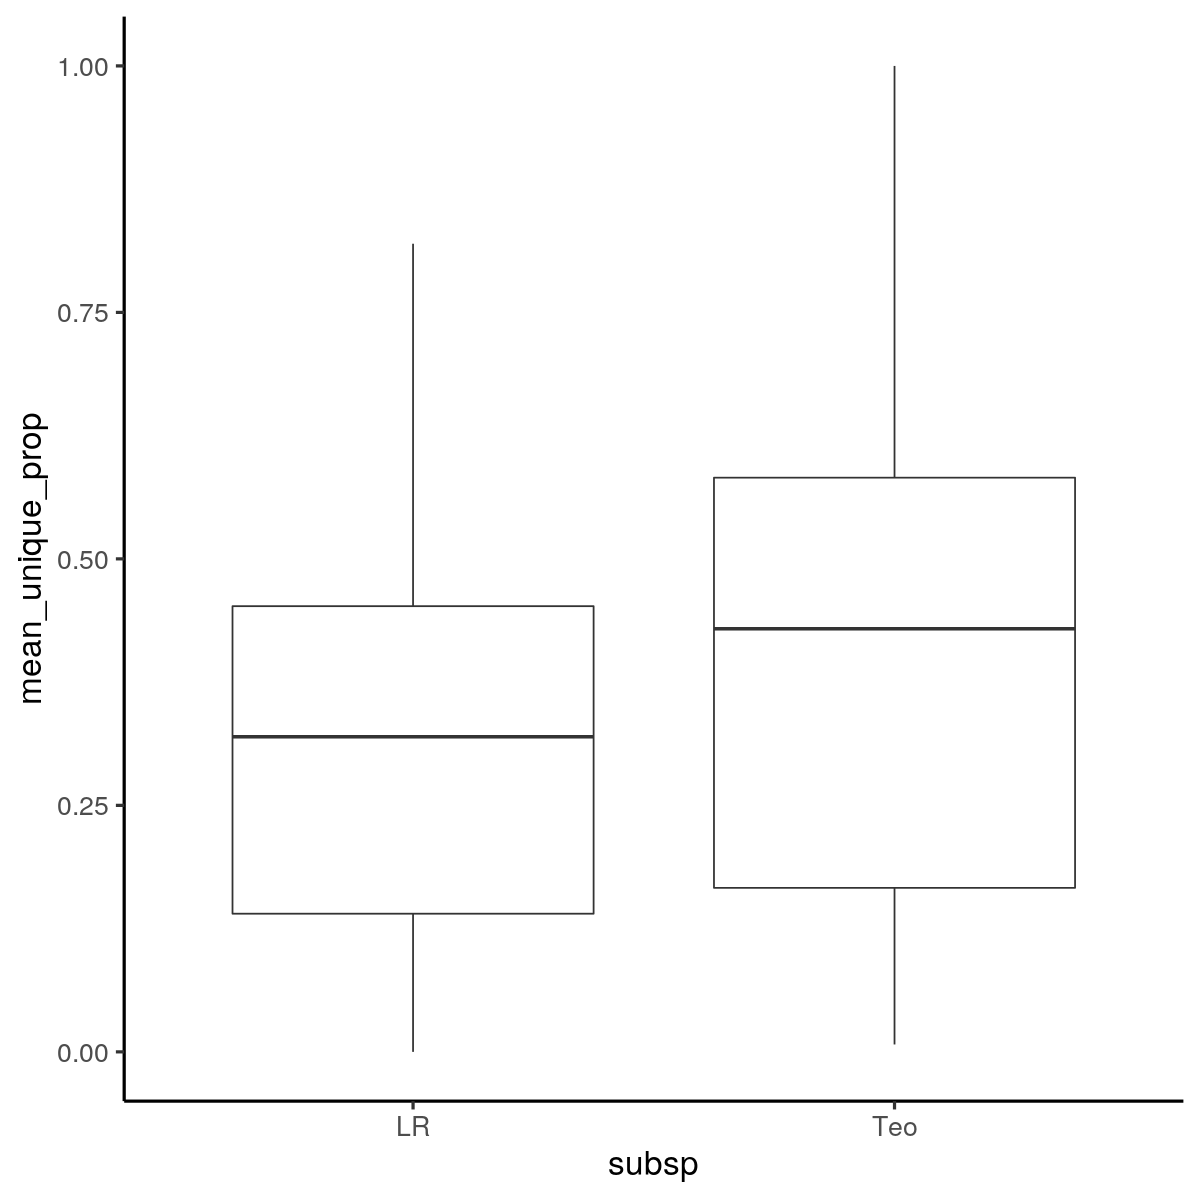

[1] 0

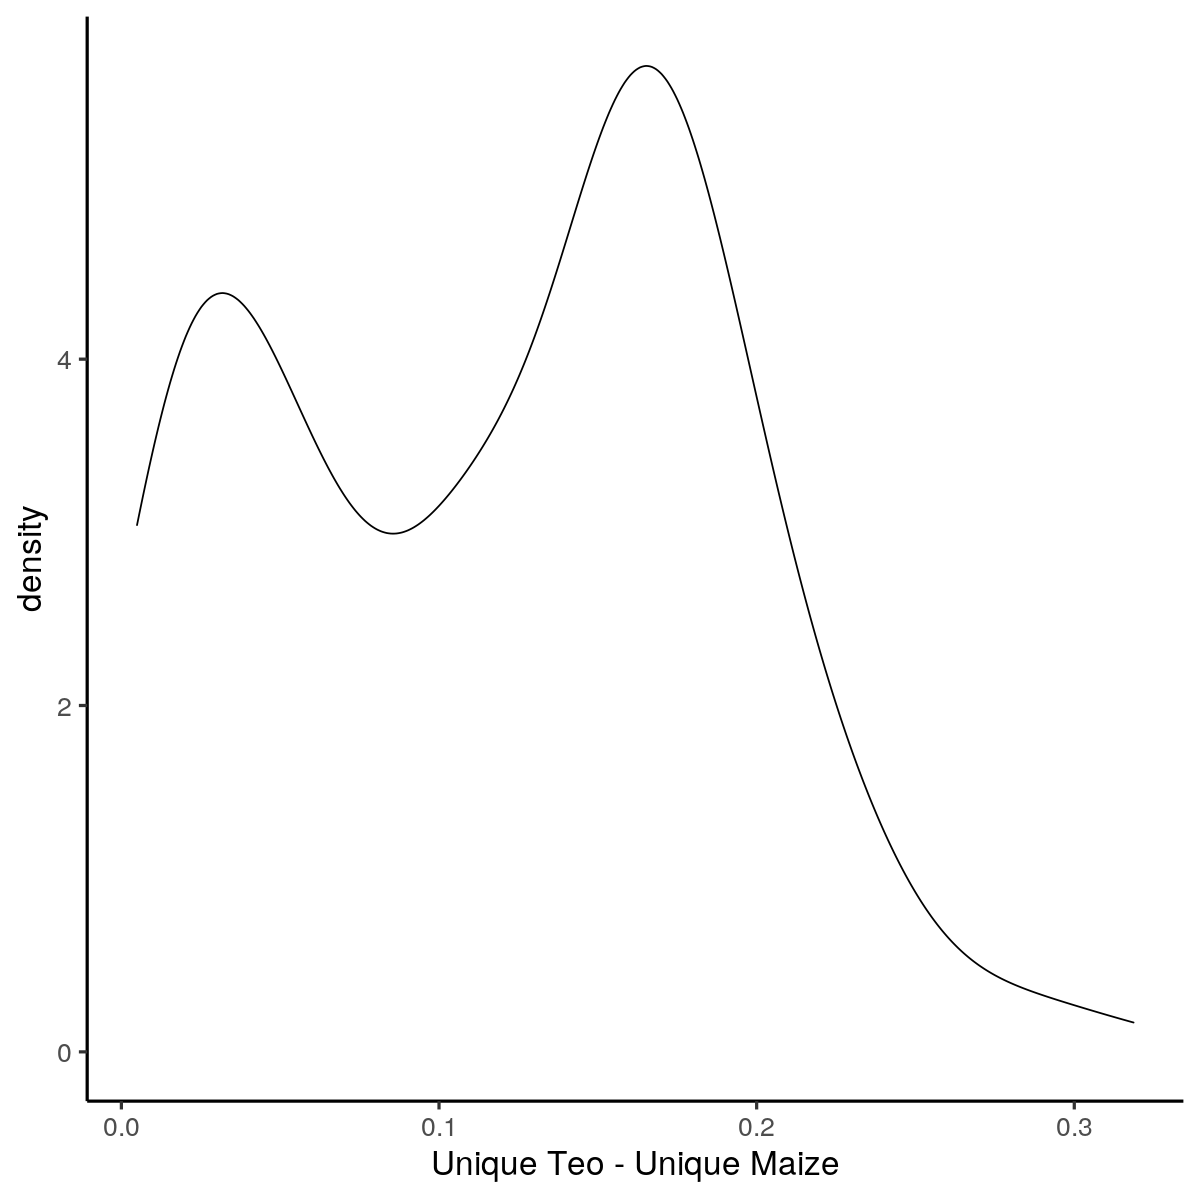

In [5]:
mean_unique_df %>% 
    ggplot(aes(subsp, mean_unique_prop)) +
    geom_boxplot()

diff_prop_df  <- mean_unique_df %>% 
    pivot_wider(id_cols = c(window, maf, quantile, merge), names_from = subsp, values_from = mean_unique_prop) %>% 
    mutate(prop_diff = Teo - LR)

diff_prop_df%>% 
    ggplot(aes(prop_diff)) +
    geom_density() +
    xlab("Unique Teo - Unique Maize")

#in only 0% of parameter combos is the mean prop unique higher in maize than teo
#no idea why the distribution of differences is bimodal
mean(diff_prop_df$prop_diff < 0, na.rm=T) * 100

total,size,LR,Teo,LR_shared,Teo_shared,LR_random1,LR_random2,Teo_random1,Teo_random2,LR_prop,Teo_prop,mean_prop,window,maf,quantile,merge,scale_prop
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3885,5.701607,1871,1777,1345,1226,1593,1623,1511,1492,0.7188669,0.6899268,0.7043969,10,0.05,0.050,1e+05,2.5283558
2578,5.866124,1215,1105,852,714,1018,1049,922,897,0.7012346,0.6461538,0.6736942,24,0.05,0.050,2e+05,2.2981615
4222,5.622225,1735,1538,1027,818,1368,1394,1218,1138,0.5919308,0.5318596,0.5618952,10,0.05,0.010,2e+05,2.0371613
17706,4.964264,6173,5343,3138,2557,4676,4635,4037,3863,0.5083428,0.4785701,0.4934564,10,0.05,0.050,5e+04,2.0962624
9438,5.213477,3235,2660,1659,1142,2430,2464,1935,1867,0.5128284,0.4293233,0.4710759,24,0.05,0.050,1e+05,1.8724701
2899,5.708083,1027,872,524,360,768,783,638,594,0.5102240,0.4128440,0.4615340,10,0.05,0.001,5e+05,1.5979453
5849,5.342625,1922,1368,900,498,1433,1389,1025,841,0.4682622,0.3640351,0.4161487,50,0.05,0.050,2e+05,1.5676660
3030,5.570808,994,644,471,208,743,722,483,369,0.4738431,0.3229814,0.3984122,50,0.05,0.010,5e+05,1.3870493
6669,5.271536,2041,1505,900,504,1469,1472,1056,953,0.4409603,0.3348837,0.3879220,24,0.05,0.010,2e+05,1.4834373


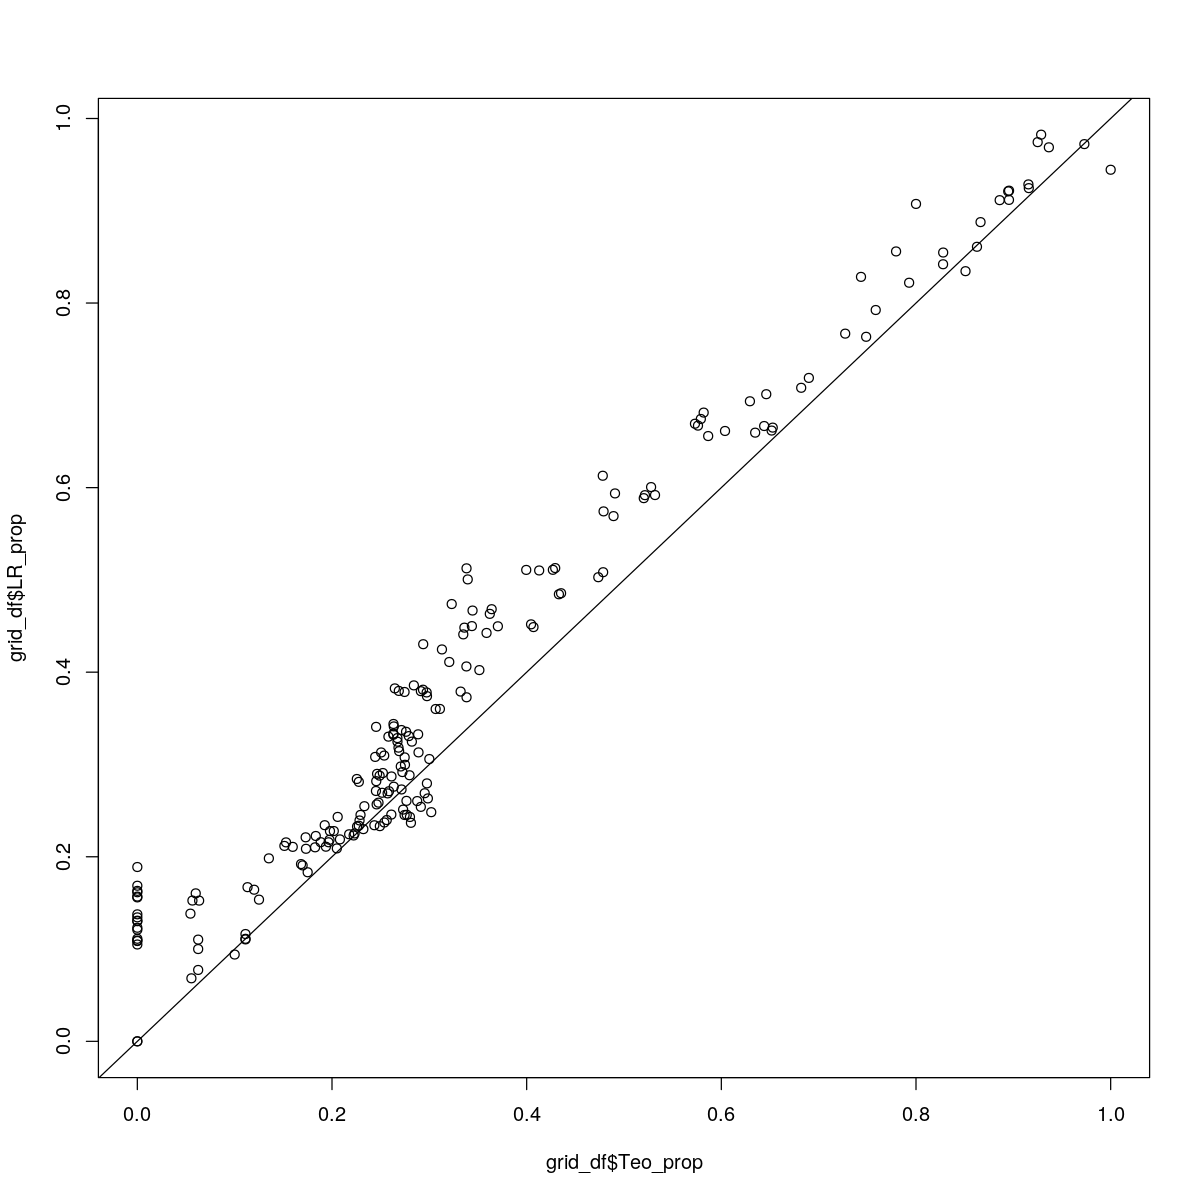

In [15]:
#now, what parameter combo should we choose?

grid_df %>% 
    mutate(scale_prop = log10(total) * mean_prop) %>%
    mutate(size = log10(size)) %>%
    arrange(desc(mean_prop), size) %>%
    filter(maf == 0.05, size < 6, quantile <=0.05) %>% 
    #filter(maf == 0.05, quantile <= 0.05, size <= 6) %>%
    #filter(quantile == 0.01, merge == 1e5, maf == 0.05, window == 100) %>% 
    #filter(quantile == 0.001, merge == 1e5, maf == 0.05, window == 100) %>% 
    head(30) 

plot(grid_df$Teo_prop, grid_df$LR_prop)
abline(0,1)

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Wed Oct 26 09:30:09 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrrrrrrrrrl}
  \hline
total & size & maize count & teosinte count & maize shared & teosinte shared & maize sample 1 & maize sample 2 & teosinte sample 1 & teosinte sample 2 & maize prop. shared & teosinte prop. shared & snp window size & maf & outlier quantile & merge window size \\ 
  \hline
 52 & 40889707.21 &  36 &  37 &  35 &  36 &  36 &  35 &  36 &  37 & 0.97 & 0.97 & 10.00 & 0.00 & 0.10 & 2e+05 \\ 
   23 & 92587807.26 &  18 &  17 &  17 &  17 &  18 &  17 &  17 &  17 & 0.94 & 1.00 & 10.00 & 0.00 & 0.20 & 2e+05 \\ 
   84 & 25267003.10 &  57 &  56 &  56 &  52 &  57 &  56 &  54 &  54 & 0.98 & 0.93 & 24.00 & 0.00 & 0.20 & 2e+05 \\ 
   86 & 24667233.92 &  64 &  63 &  62 &  59 &  64 &  62 &  62 &  60 & 0.97 & 0.94 & 24.00 & 0.05 & 0.20 & 2e+05 \\ 
   49 & 43304069.04 &  39 &  40 &  38 &  37 &  38 &  39 &  39 &  38 & 0.97 & 0.93 & 50.00 & 0.05 & 0.20 & 5e

Warning message:
“Removed 37 rows containing missing values (geom_point).”
Warning message:
“Removed 37 rows containing missing values (geom_point).”


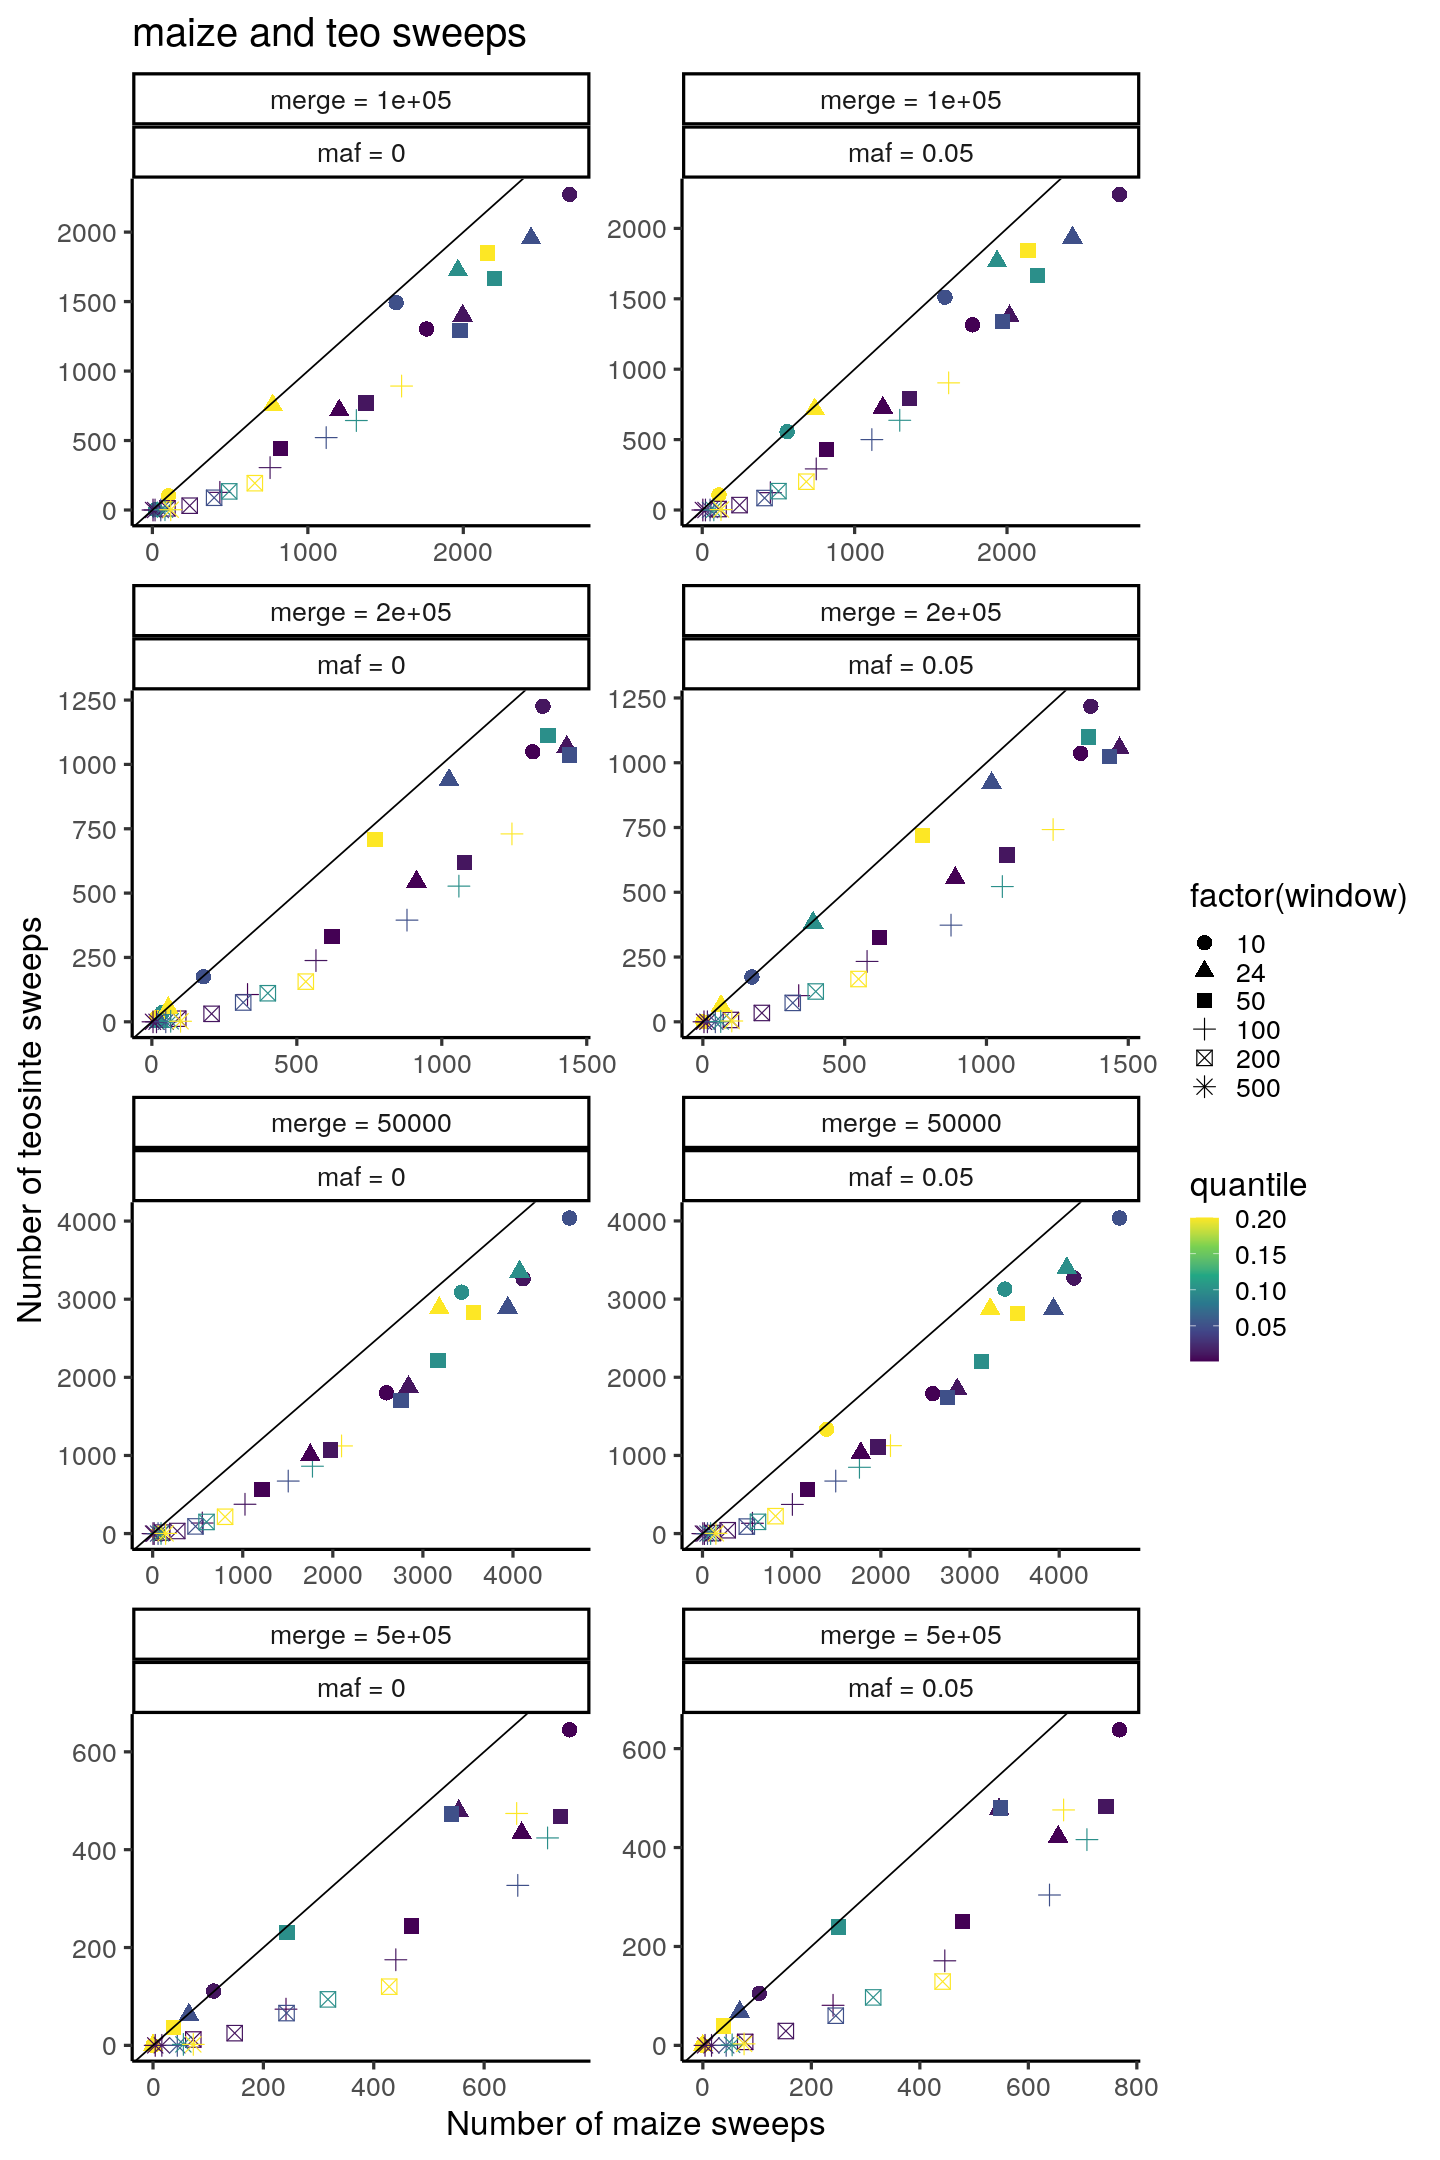

[1] 0.3605971

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 37 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 37 rows containing non-finite values (stat_bin).”


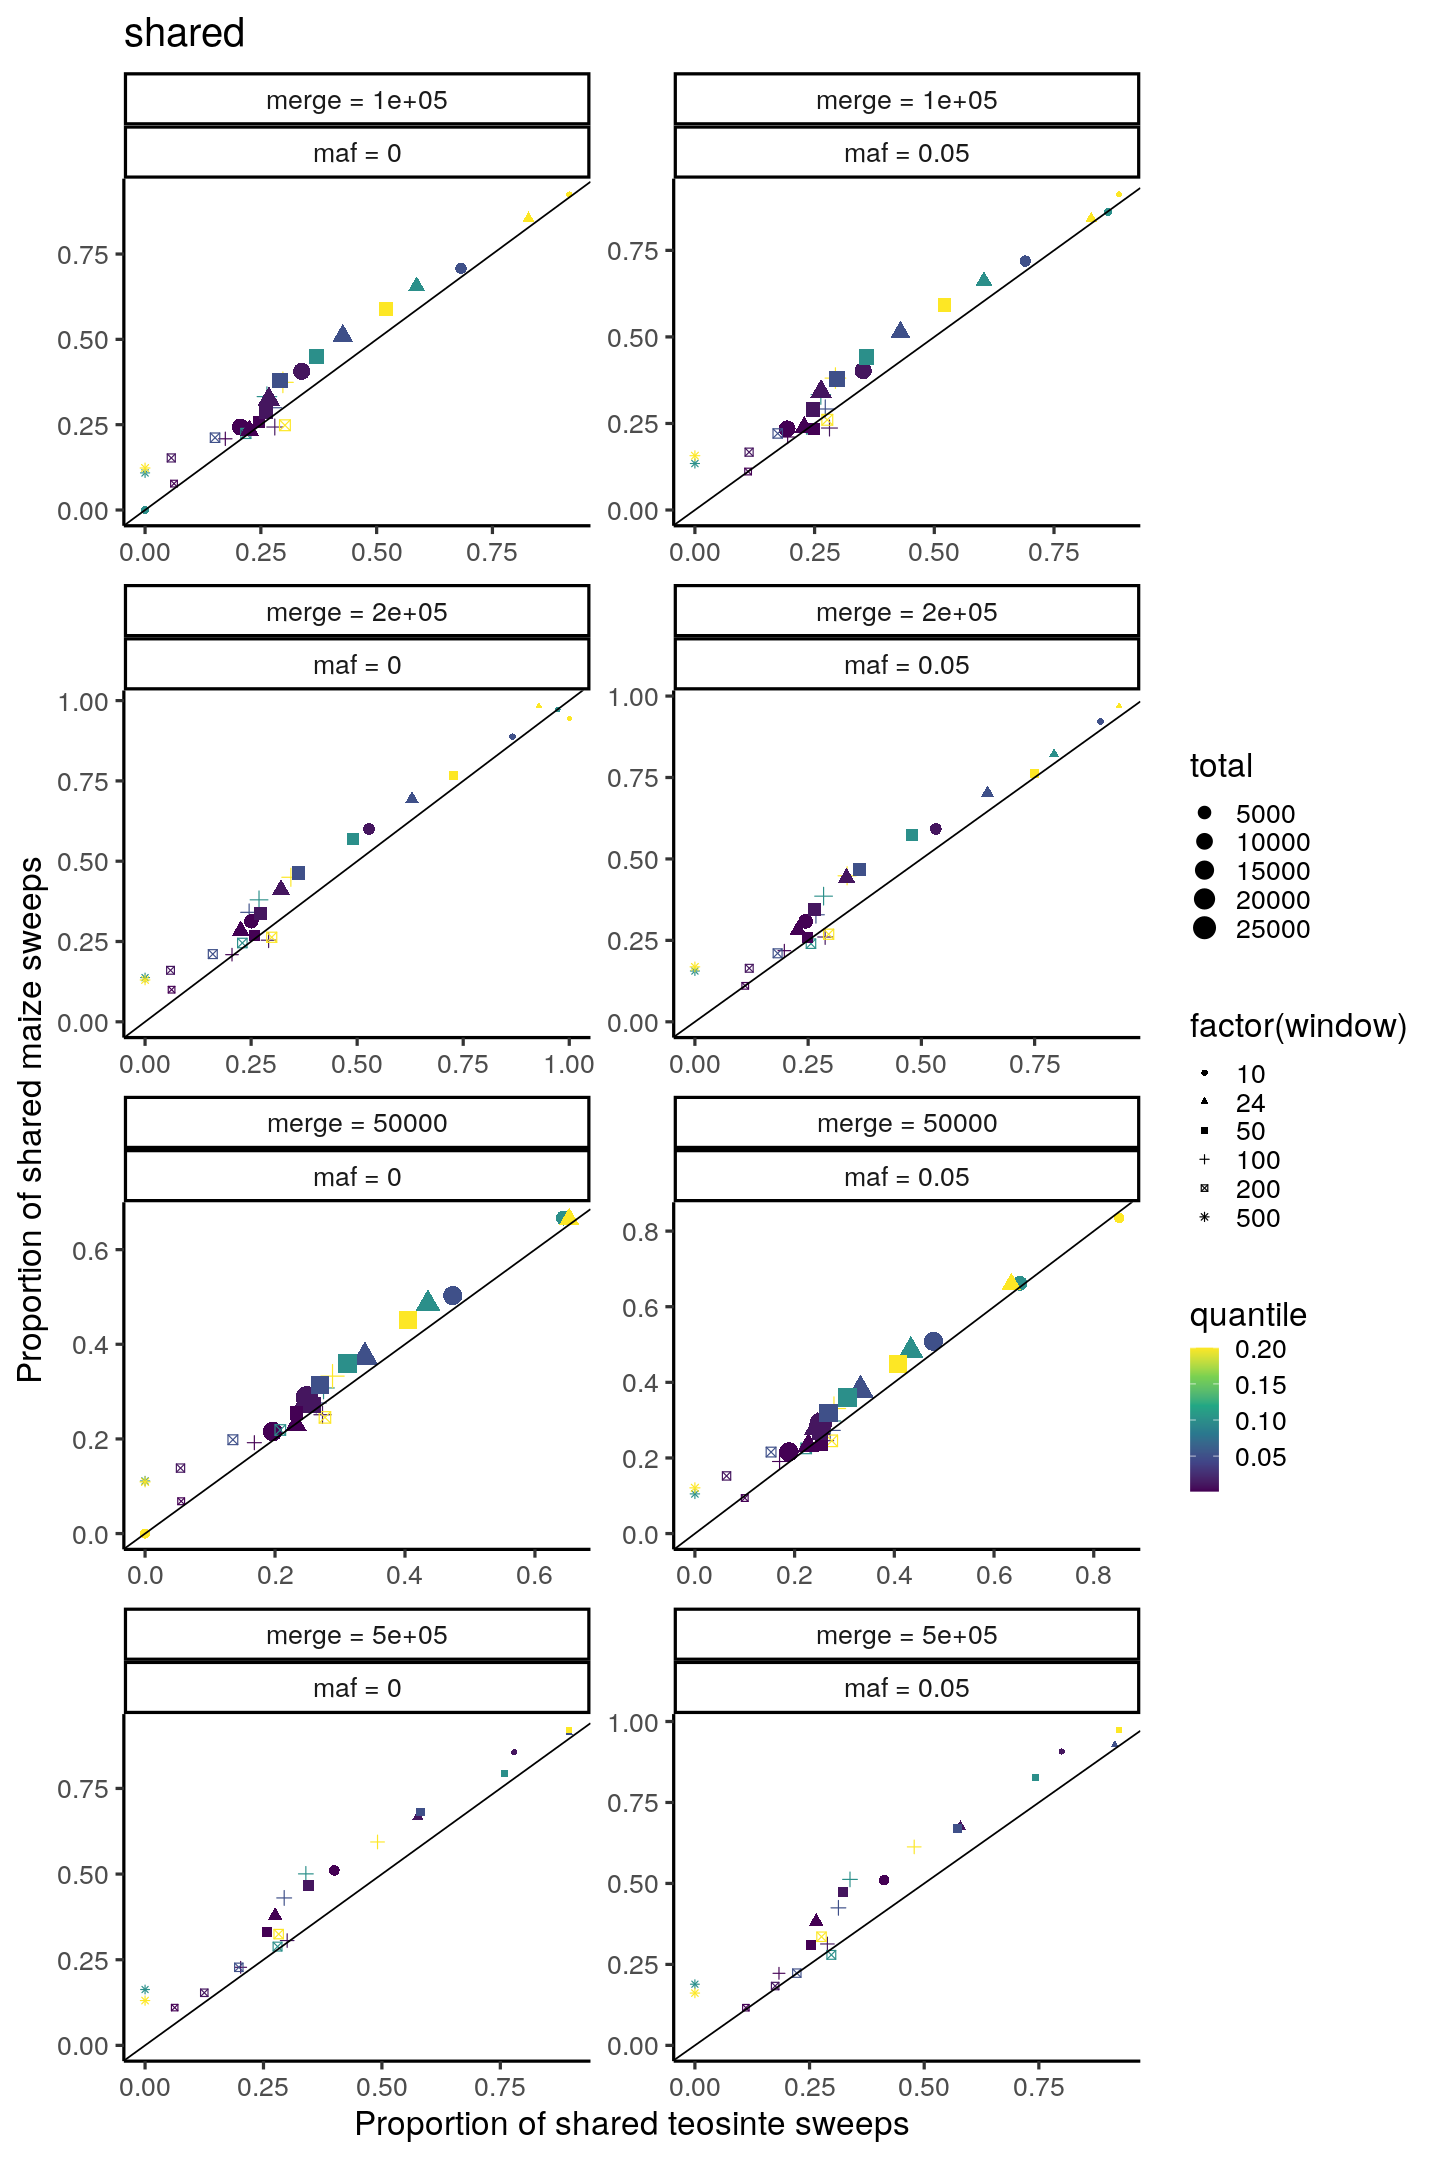

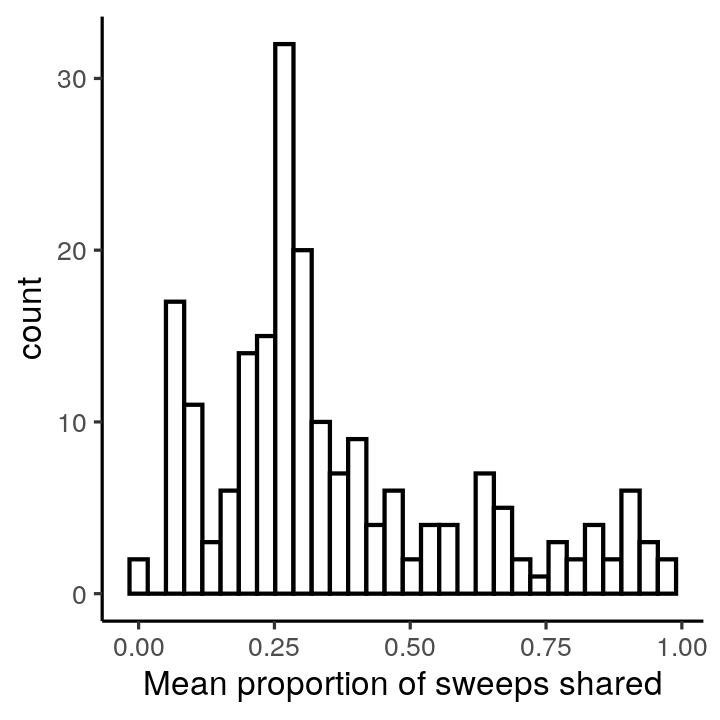

In [7]:
options(repr.plot.width=12, repr.plot.height=18)

grid_df %>% 
    mutate(scale_prop = log10(total) * mean_prop) %>%
    mutate(merge = factor(merge)) %>% 
    arrange(desc(mean_prop)) %>%
    filter(total > 1) %>% 
    head(30) %>% 
    select(-scale_prop, -mean_prop) %>% 
    rename(
    "maize count" = LR,
    "teosinte count" = Teo,
    "maize shared" = LR_shared,
    "teosinte shared" = Teo_shared,
    "maize sample 1" = LR_random1,
    "maize sample 2" = LR_random2,
    "teosinte sample 1" = Teo_random1,
    "teosinte sample 2" = Teo_random2,
    "maize prop. shared" = LR_prop,
    "teosinte prop. shared" = Teo_prop,
    "snp window size" = window,
    "outlier quantile" = quantile,
    "merge window size" = merge
    ) %>% 
    xtable::xtable(digits=2) %>% 
    xtable::print.xtable(include.rownames=FALSE)


plot_grid_df <- grid_df %>% 
    mutate(
        merge = paste0("merge = ", merge),
        maf = paste0("maf = ", maf)
    )

plot_grid_df %>% 
    ggplot() +
    geom_point(aes(LR_random1, Teo_random1, colour = quantile, shape = factor(window)), size = 4) +
    geom_abline(intercept = 0, slope = 1) +
    facet_wrap(~factor(merge) + factor(maf), scales = "free", ncol = 2) +
    scale_colour_viridis_c() +
    xlab("Number of maize sweeps") +
    ylab("Number of teosinte sweeps") +
    ggtitle("maize and teo sweeps") +
    ggsave("../../figures/supplement_raisd_search_count.pdf", width = 12, height = 18)


plot_grid_df %>% 
    ggplot() +
    geom_point(aes(Teo_prop, LR_prop, colour = quantile, shape = factor(window), size = total)) +
    geom_abline(intercept = 0, slope = 1) +
    facet_wrap(~factor(merge) + factor(maf), scales = "free", ncol = 2) +
    scale_colour_viridis_c() +
    xlab("Proportion of shared teosinte sweeps") +
    ylab("Proportion of shared maize sweeps") +
    ggtitle("shared") +
    ggsave("../../figures/supplement_raisd_search_prop.pdf", width = 12, height = 18)


options(repr.plot.width=6, repr.plot.height=6)
mean(grid_df$mean_prop, na.rm=T)
grid_df %>% 
    ggplot(aes(mean_prop)) +
    xlab("Mean proportion of sweeps shared") +
    geom_histogram(fill = "white", colour = "black", lwd = 1.2) +
    ggsave("../../figures/supplement_raisd_search_hist.pdf", width = 12, height = 12)

[1] 0.001

total,size,LR,Teo,LR_shared,Teo_shared,LR_random1,LR_random2,Teo_random1,Teo_random2,LR_prop,Teo_prop,mean_prop,window,maf,quantile,merge
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4603,53454.94,1351,594,315,148,815,851,429,313,0.2331606,0.2491582,0.2411594,50,0.05,0.001,1e+05


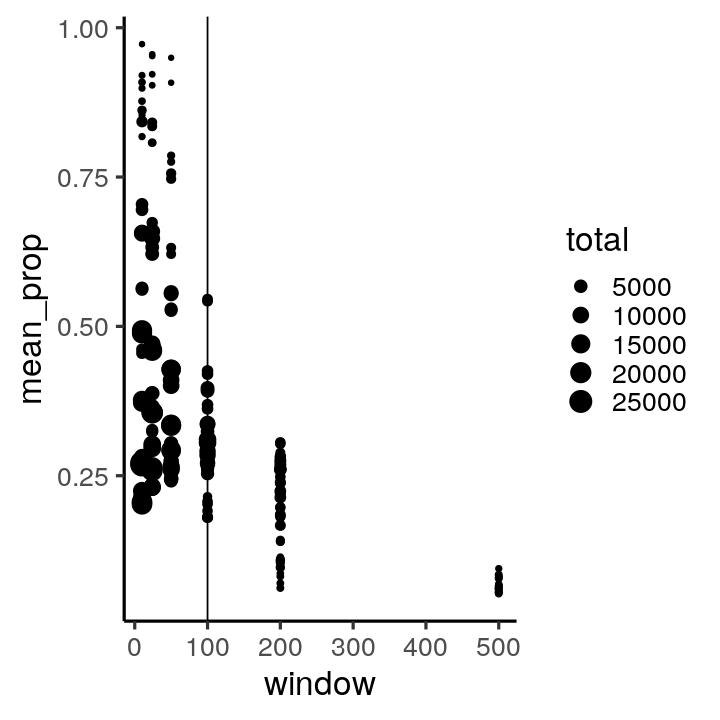

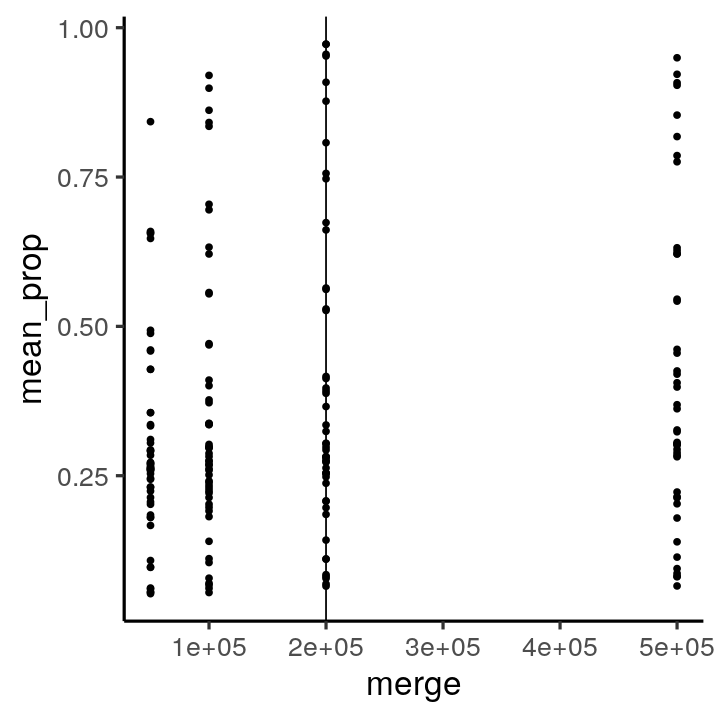

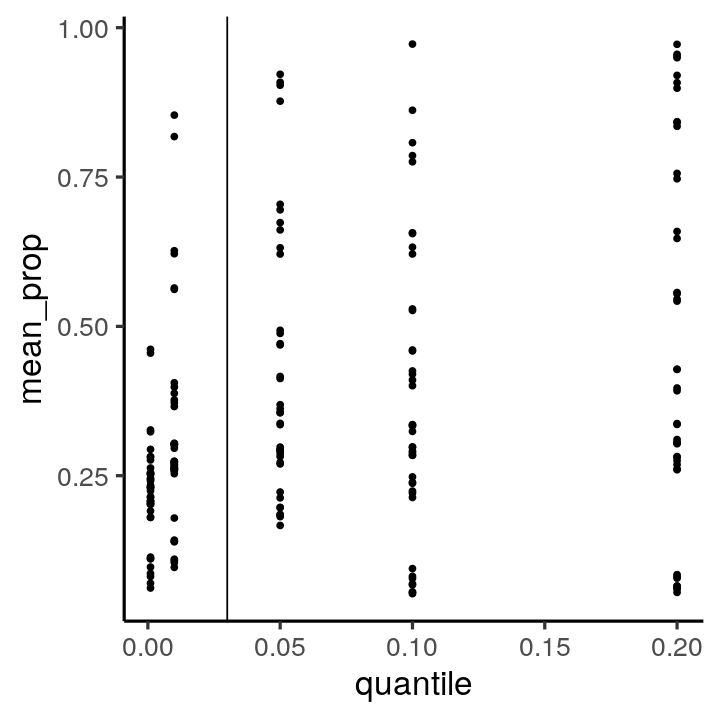

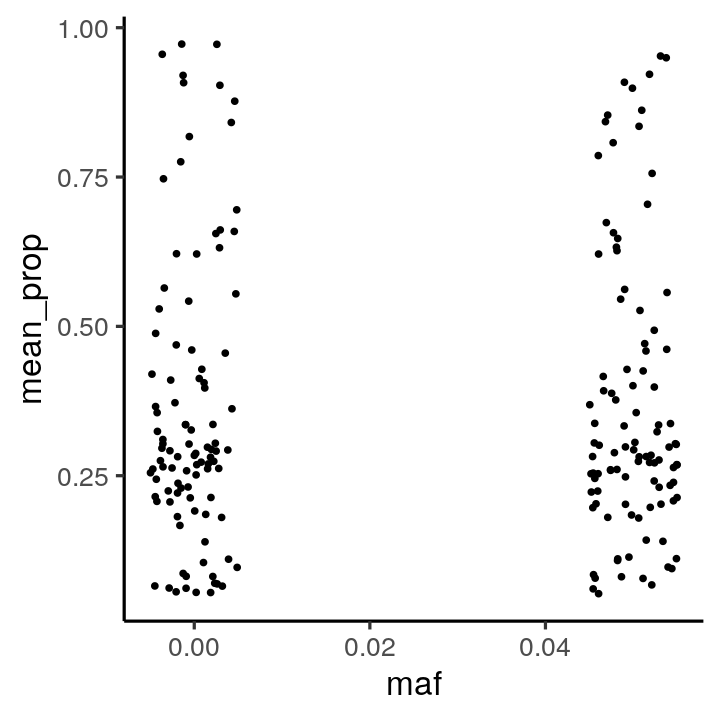

In [8]:
min(grid_df$quantile)
grid_df %>% 
    arrange(desc(mean_prop)) %>% 
    filter(merge == 1e5, quantile == 0.001, window == 50, maf == 0.05)

ggplot(drop_na(grid_df), aes(window, mean_prop, size = total)) + geom_point() + geom_vline(xintercept = 100)
ggplot(drop_na(grid_df), aes(merge, mean_prop)) + geom_point() + geom_vline(xintercept = 2e5)
ggplot(drop_na(grid_df), aes(quantile, mean_prop)) + geom_point() + geom_vline(xintercept = 0.03)
ggplot(drop_na(grid_df), aes(maf, mean_prop)) + geom_jitter(height = 0, width = 0.005)


In [9]:
#small quantiles, decent number of sweeps 
grid_df %>%
    filter(quantile < 0.05, maf == 0.05, total > 10) %>% 
    arrange(desc(mean_prop))

total,size,LR,Teo,LR_shared,Teo_shared,LR_random1,LR_random2,Teo_random1,Teo_random2,LR_prop,Teo_prop,mean_prop,window,maf,quantile,merge
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
182,11514715.97,108,120,98,96,104,102,105,111,0.90740741,0.80000000,0.8537037,10,0.05,0.010,5e+05
1449,1264444.79,648,589,437,341,546,539,478,452,0.67438272,0.57894737,0.6266650,24,0.05,0.010,5e+05
4222,419010.96,1735,1538,1027,818,1368,1394,1218,1138,0.59193084,0.53185956,0.5618952,10,0.05,0.010,2e+05
2899,510602.18,1027,872,524,360,768,783,638,594,0.51022395,0.41284404,0.4615340,10,0.05,0.001,5e+05
3030,372226.79,994,644,471,208,743,722,483,369,0.47384306,0.32298137,0.3984122,50,0.05,0.010,5e+05
6669,186868.28,2041,1505,900,504,1469,1472,1056,953,0.44096031,0.33488372,0.3879220,24,0.05,0.010,2e+05
13225,102427.20,3955,3190,1591,1121,2738,2808,2241,2070,0.40227560,0.35141066,0.3768431,10,0.05,0.010,1e+05
3413,269086.19,991,601,379,159,655,715,422,338,0.38244198,0.26455907,0.3235005,24,0.05,0.001,5e+05
5798,124354.57,1579,874,543,230,1073,1049,644,460,0.34388854,0.26315789,0.3035232,50,0.05,0.010,2e+05


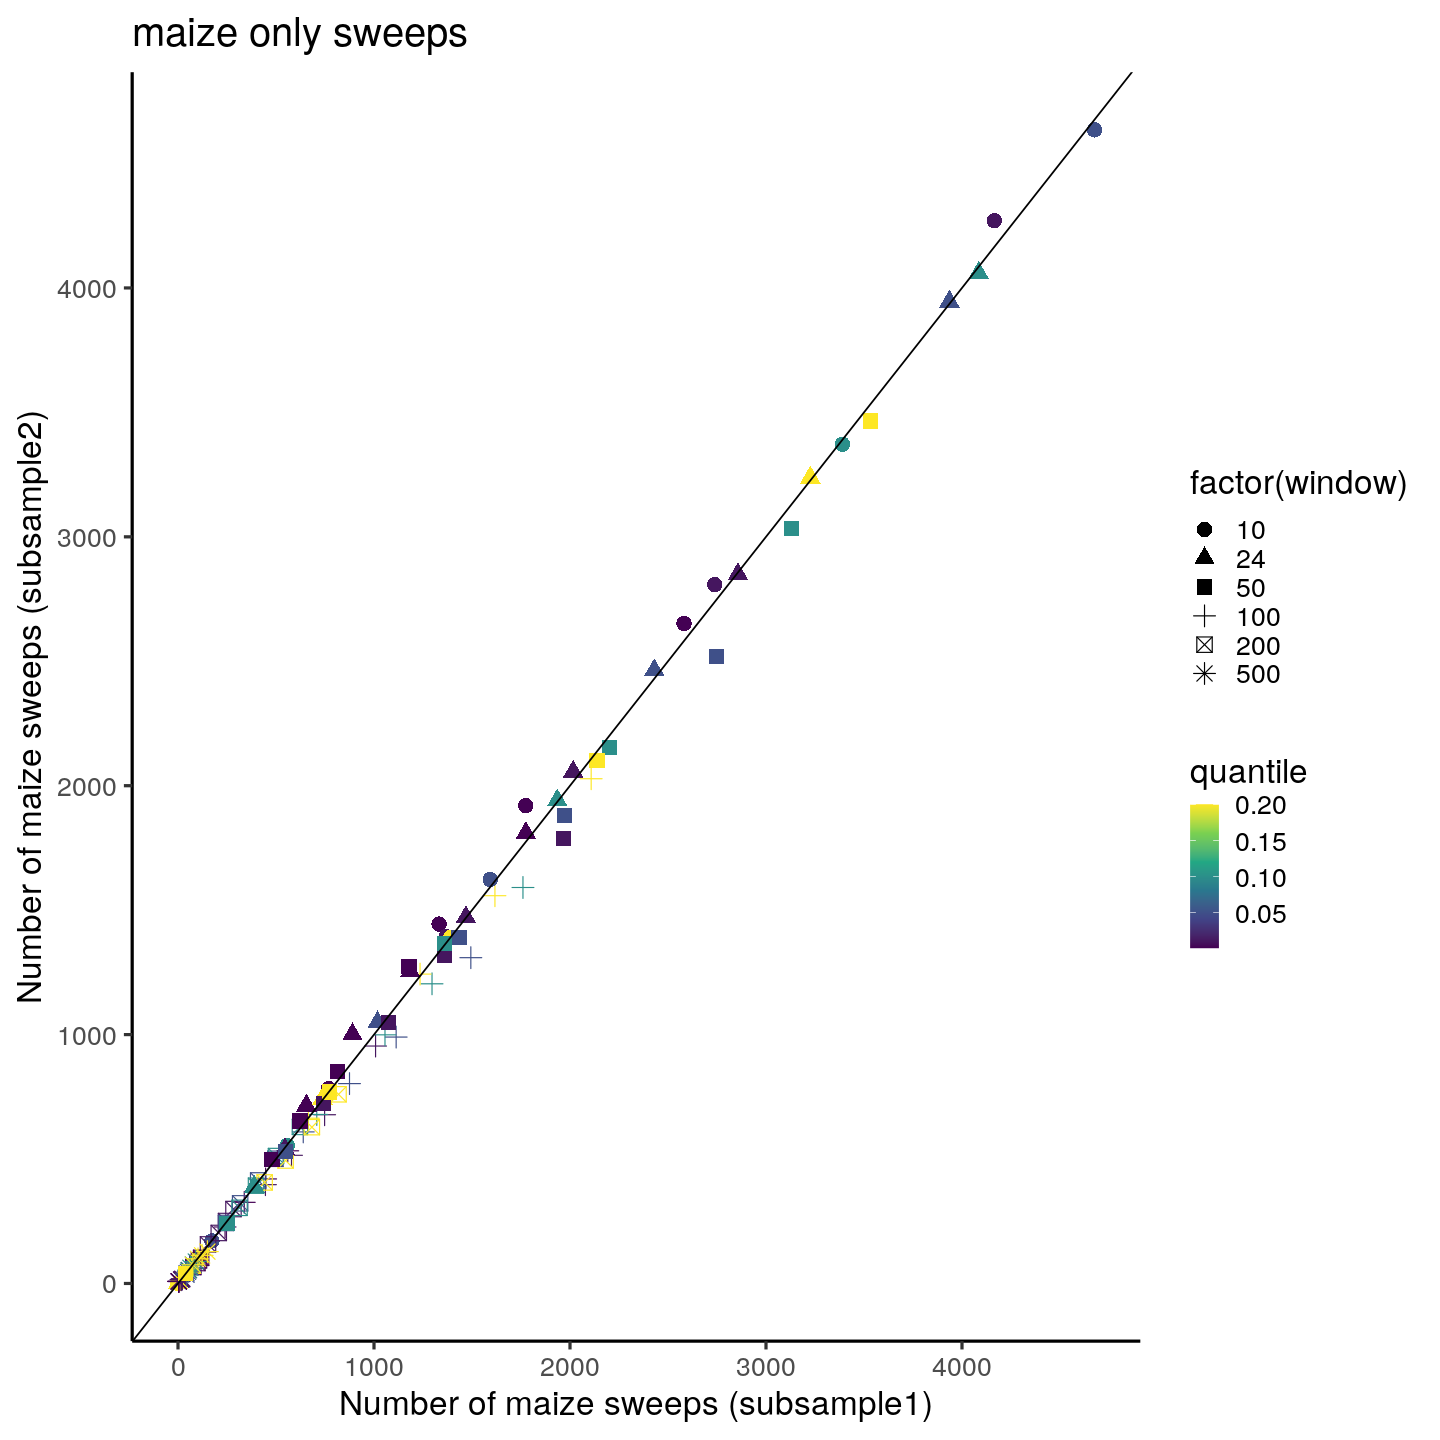

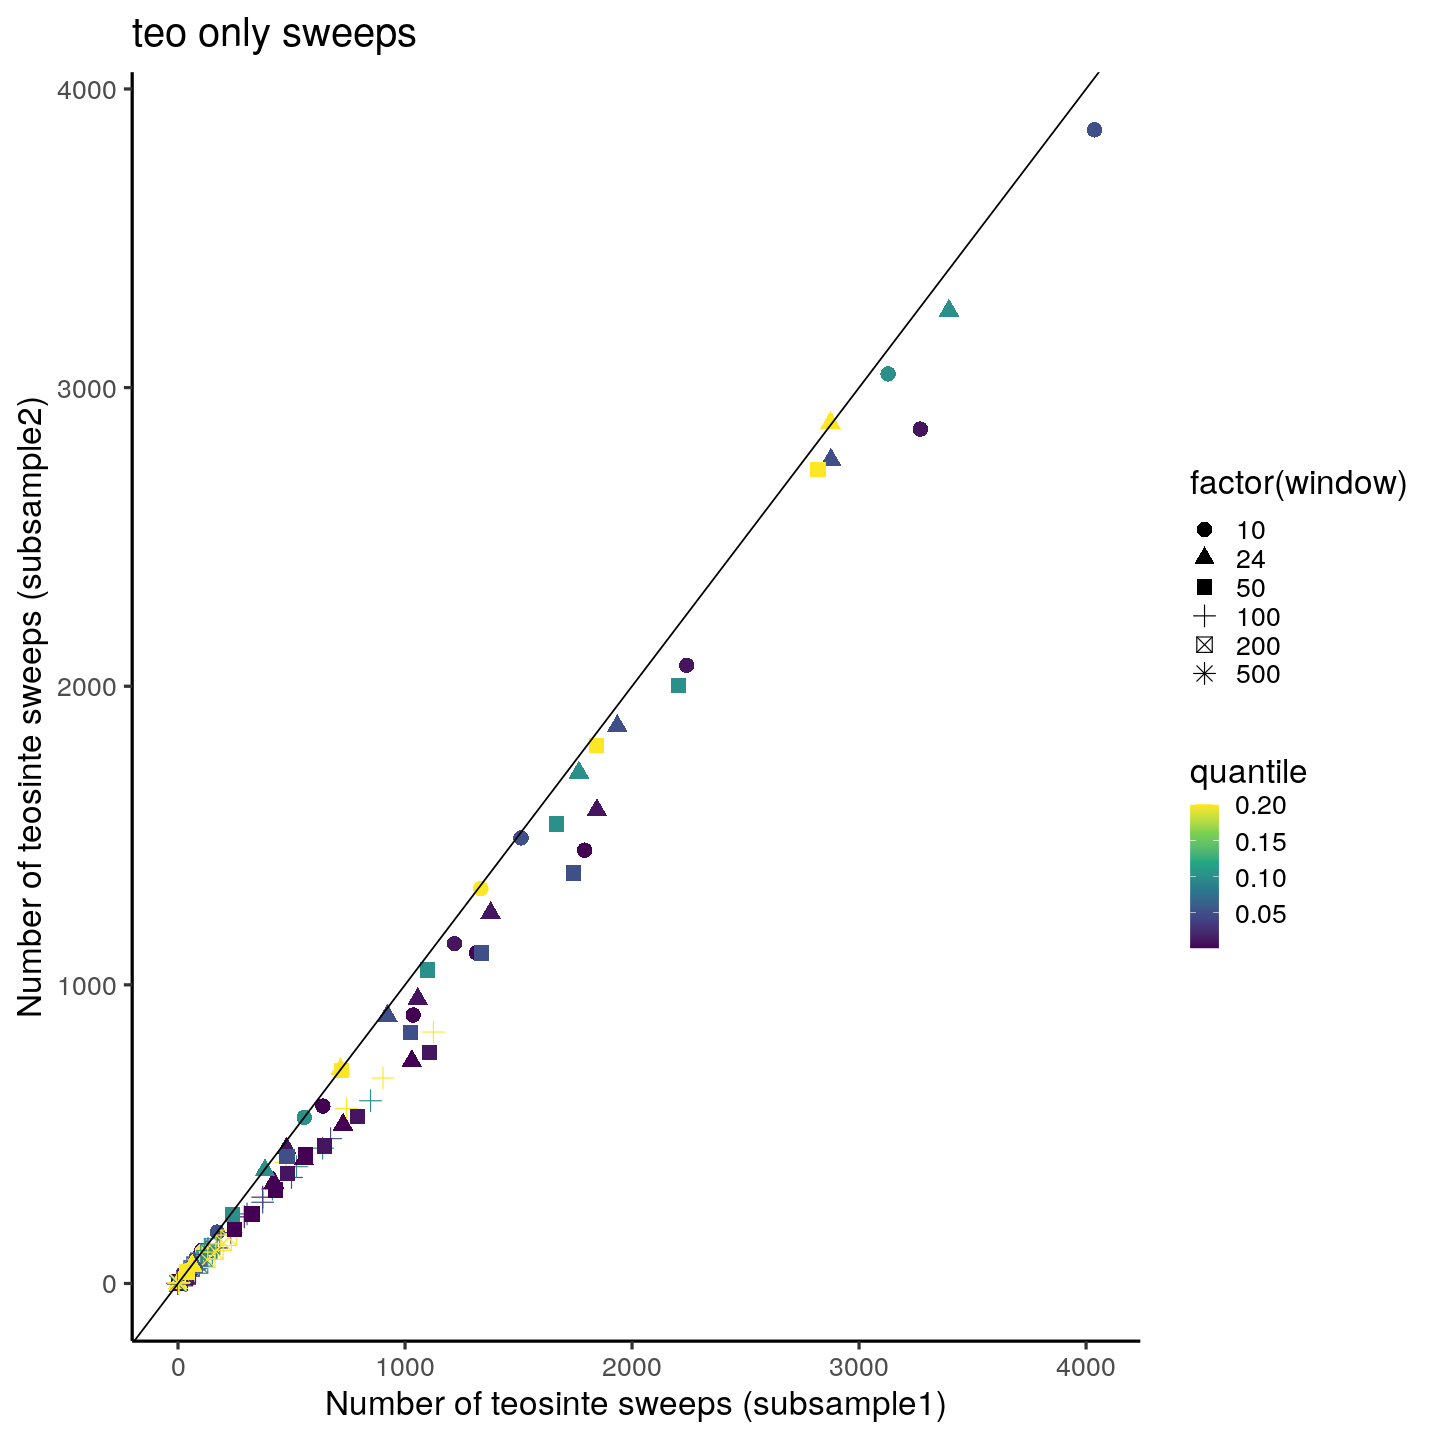

[1] 100  10 200  24 500  50

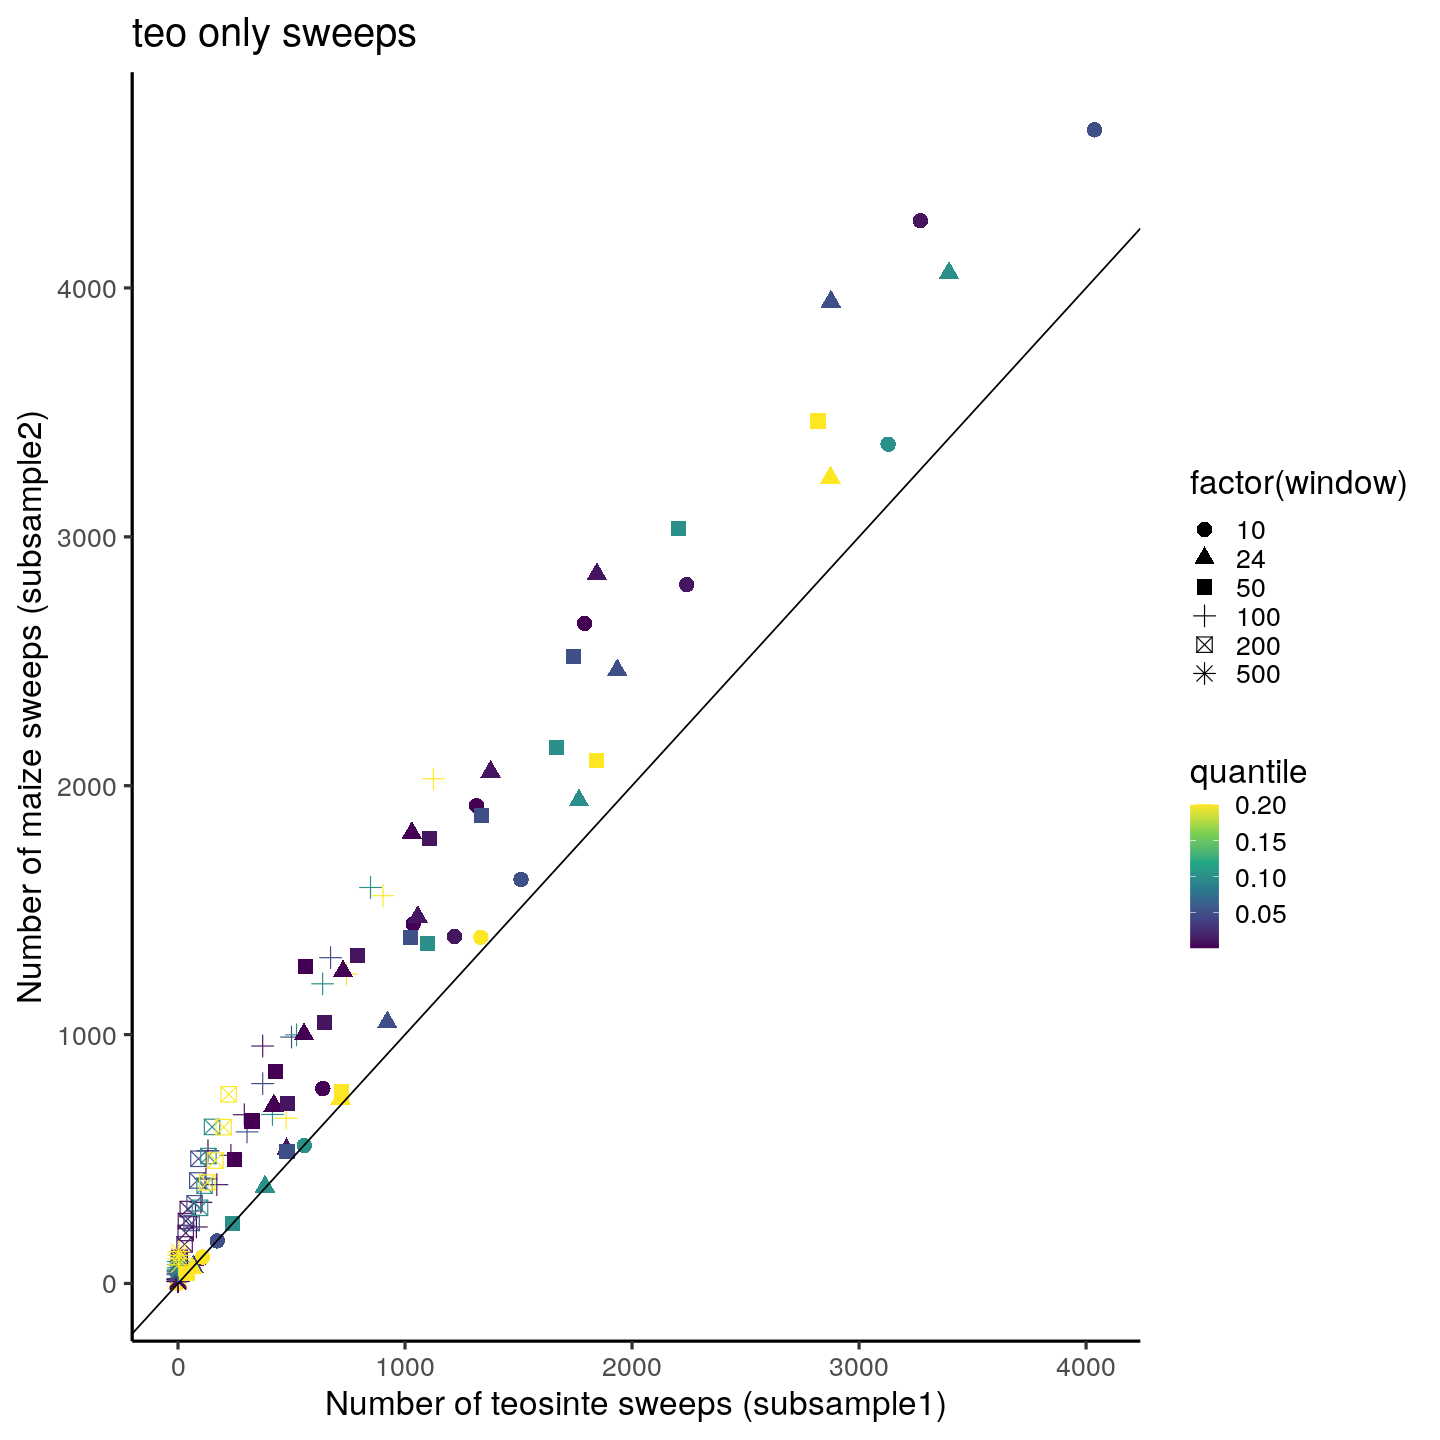

In [11]:
options(repr.plot.width=12, repr.plot.height=12)


grid_df %>% 
    filter(maf == 0.05) %>% 
    ggplot() +
    geom_point(aes(LR_random1, LR_random2, colour = quantile, shape = factor(window)), size = 4) +
    geom_abline(intercept = 0, slope = 1) +
    scale_colour_viridis_c() +
    xlab("Number of maize sweeps (subsample1)") +
    ylab("Number of maize sweeps (subsample2)") +
    ggtitle("maize only sweeps")


grid_df %>% 
    filter(maf == 0.05) %>% 
    ggplot() +
    geom_point(aes(Teo_random1, Teo_random2, colour = quantile, shape = factor(window)), size = 4) +
    geom_abline(intercept = 0, slope = 1) +
    scale_colour_viridis_c() +
    xlab("Number of teosinte sweeps (subsample1)") +
    ylab("Number of teosinte sweeps (subsample2)") +
    ggtitle("teo only sweeps")




grid_df %>% 
    filter(maf == 0.05) %>% 
    ggplot() +
    geom_point(aes(Teo_random1, LR_random2, colour = quantile, shape = factor(window)), size = 4) +
    geom_abline(intercept = 0, slope = 1) +
    scale_colour_viridis_c() +
    xlab("Number of teosinte sweeps (subsample1)") +
    ylab("Number of maize sweeps (subsample2)") +
    ggtitle("teo only sweeps")


unique(grid_df$window)



A lot going on in the plots above, but take home is maize almost always has more sweeps than teo regardless of parameter combinations. When the sweep count is close to one to one, snps windows were small, merge windows are large, and quantiles were high -- all of which are zones that are likely to have higer false positives. 

# 

In [ ]:
#jeff meeting notes
#anything interesting about params near 1 to 1?

#use sims to support biological reasons for false positives
#use grid search, parameter choices matter, but global average is similar to our initial parameter choices 
#rdmc is independent check and agrees
#meaningful number of teo sweeps shared, but hard to know exact numbers